In [160]:
import sys 
sys.path.append('../../')
import_path = '../export/'

In [161]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=10000, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)

In [162]:

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.utils import to_categorical
from art.attacks.inference.membership_inference import ShadowModels
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier
from Helpers import twod_laplace


def train_model(X_train, y_train):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    # test data for attack model

    return clf
    
def run_mi_experiments(epsilons, n_times = 10): 
    shokri_mi_avgs = {'epsilon': [], 'shokri_mi': [], 'run': []}
    create_labels = KMeans(init='random', n_clusters=4)
    X_pd = pd.DataFrame(X, columns=['X', 'Y'])
    create_labels.fit(StandardScaler().fit_transform(X_pd))
    X_pd['target'] = create_labels.labels_
    for epsilon in epsilons:
        for run in range(n_times):
            shokri_mi_avgs['epsilon'].append(epsilon)
            shokri_mi_avgs['run'].append(run)
            _, _, Z = twod_laplace.generate_truncated_laplace_noise(X, epsilon)
            Z_pd = pd.DataFrame(Z, columns=['X', 'Y'])
            Z_pd['target'] = create_labels.labels_

            shadow_ratio = 0.75
            dataset = train_test_split(X_pd.iloc[:, 0:2], X_pd['target'], test_size=shadow_ratio)

            x_target, x_shadow, y_target, y_shadow = dataset

            target_train_size = len(x_target) // 2
            x_target_train = x_target[:target_train_size]
            y_target_train = y_target[:target_train_size]
            x_target_test = x_target[target_train_size:]
            y_target_test = y_target[target_train_size:]

            # We infer based on the original data, to make sure we can estimate the dp protection
            #x_shadow_np = Z_pd.iloc[x_shadow.index, 0:2].to_numpy()
            # y_shadow_np = Z_pd.iloc[y_shadow.index, 2].to_numpy()
            x_shadow_np = x_shadow.to_numpy()
            y_shadow_np = y_shadow.to_numpy()
            
            classifier = train_model(x_target_train, y_target_train)
            art_classifier = ScikitlearnRandomForestClassifier(classifier)

            ## train shadow models
            shadow_models = ShadowModels(art_classifier, num_shadow_models=3)
            shadow_dataset = shadow_models.generate_shadow_dataset(x_shadow_np, to_categorical(y_shadow_np, 4))
            (member_x, member_y, member_predictions), (nonmember_x, nonmember_y, nonmember_predictions) = shadow_dataset

            ## Execute membership attack
            attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")
            attack.fit(member_x, member_y, nonmember_x, nonmember_y, member_predictions, nonmember_predictions)

            member_infer = attack.infer(x_target_train, y_target_train)
            nonmember_infer = attack.infer(x_target_test, y_target_test)
        
            # concatenate everything and calculate roc curve
            predicted_y = np.concatenate((member_infer, nonmember_infer))
            actual_y = np.concatenate((np.ones(len(member_infer)), np.zeros(len(nonmember_infer))))
            fpr, tpr, _ = roc_curve(actual_y, predicted_y, pos_label=1)
            attack_adv = tpr[1] - fpr[1]
            shokri_mi_avgs['shokri_mi'].append(attack_adv)
    
    return pd.DataFrame(shokri_mi_avgs)

In [163]:
epsilons = [0.05, 0.5, 1, 2, 3, 4, 5, 10, 100]
shokri_mi_avgs = run_mi_experiments(epsilons, 5)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff4420c160>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3cbd0820>
Traceback 

In [164]:
shokri_mi_avgs

,epsilon,shokri_mi,run
0,0.05,0.1160,0
1,0.05,0.1024,1
2,0.05,0.1328,2
3,0.05,0.0736,3
4,0.05,0.1176,4
5,0.50,0.1000,0
6,0.50,0.0808,1
7,0.50,0.0696,2
8,0.50,0.0968,3
9,0.50,0.1144,4


In [165]:
avg_mi = shokri_mi_avgs.groupby('epsilon').mean()['shokri_mi']

In [166]:
#avg_mi = 1 - avg_mi

In [167]:
avg_mi

epsilon
0.05      0.10848
0.50      0.09232
1.00      0.10272
2.00      0.08352
3.00      0.11088
4.00      0.09776
5.00      0.08288
10.00     0.10512
100.00    0.08528
Name: shokri_mi, dtype: float64

In [168]:
avg_std = shokri_mi_avgs.groupby('epsilon').std()['shokri_mi']
avg_std = np.std(avg_std)
avg_std

0.003827436102137218

Text(0, 0.5, 'Privacy Leakage')

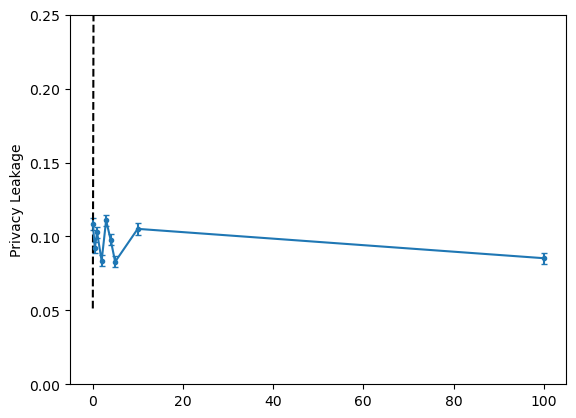

In [169]:
from matplotlib import pyplot as plt


def theoretical_limit(epsilons):
	return [np.exp(eps) - 1 for eps in epsilons]

def pretty_position(X, Y, pos):
	return ((X[pos] + X[pos+1]) / 2, (Y[pos] + Y[pos+1]) / 2)



bottom, top = plt.ylim()
plt.errorbar(epsilons, theoretical_limit(epsilons), color='black', fmt='--', capsize=2, label='Theoretical Limit')
plt.errorbar(epsilons, avg_mi, yerr=avg_std, fmt='.-', capsize=2)
plt.ylim(bottom, 0.25)
plt.annotate("$\epsilon$-DP Bound", pretty_position(epsilons, theoretical_limit(epsilons), 4), textcoords="offset points", xytext=(5,0), ha='left')
plt.yticks(np.arange(0, 0.26, step=0.05))
plt.ylabel('Privacy Leakage')